# Data analysis of NLP Disaster tweets

This notebook is used for data exploration

In [1]:
%matplotlib inline

import spacy
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from urllib.parse import unquote
import preprocessor as tweet_preprocessor

with open("params.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

plt.rcParams['figure.figsize'] = [30, 5]
pd.set_option('display.max_rows', 10)

spacy.prefer_gpu()
nlp = spacy.load(config["spacy_model"])

number_most_common_features = 30

## Table of Contents

* [Overall data exploration](#Overall-data-exploration)
* [Information extraction from tweets](#Information-extraction-from-tweets)
* [Correlate features with disaster/not disaster target](#Correlate-features-with-disaster/not-disaster-target)
    * [Most common tokens in each class](#Most-common-tokens-in-each-class)
    * [Number of tokens per example in each class](#Number-of-tokens-per-example-in-each-class)
* [Conclusions](#Conclusions)

## Overall data exploration

In [2]:
dataset = pd.read_csv(config["raw_dataset_path"], index_col = 0)

In [3]:
dataset.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
dataset.describe(include = 'all')

,keyword,location,text,target
count,7552,5080,7613,7613.00000
unique,221,3341,7503,NaN
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,45,104,10,NaN
mean,NaN,NaN,NaN,0.42966
...,...,...,...,...
min,NaN,NaN,NaN,0.00000
25%,NaN,NaN,NaN,0.00000
50%,NaN,NaN,NaN,0.00000
75%,NaN,NaN,NaN,1.00000


In [5]:
dataset.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
dataset.duplicated().sum()

52

In [7]:
dataset[dataset.duplicated()]

,keyword,location,text,target
id,,,,
68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
907,bioterrorism,NaN,To fight bioterrorism sir.,1
...,...,...,...,...
9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1


In [8]:
dataset["keyword"][dataset["keyword"].notnull()].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
dataset["location"][dataset["location"].notnull()].value_counts()

USA                         104
New York                     71
United States                50
London                       45
Canada                       29
                           ... 
Moscow, Russia                1
Jammu | Kashmir | Delhi       1
L. A.                         1
Elchilicitanierraversal       1
Charleston S.C.               1
Name: location, Length: 3341, dtype: int64

In [10]:
dataset["text"]

id
1        Our Deeds are the Reason of this #earthquake M...
4                   Forest fire near La Ronge Sask. Canada
5        All residents asked to 'shelter in place' are ...
6        13,000 people receive #wildfires evacuation or...
7        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
10869    Two giant cranes holding a bridge collapse int...
10870    @aria_ahrary @TheTawniest The out of control w...
10871    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
10872    Police investigating after an e-bike collided ...
10873    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [11]:
dataset["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

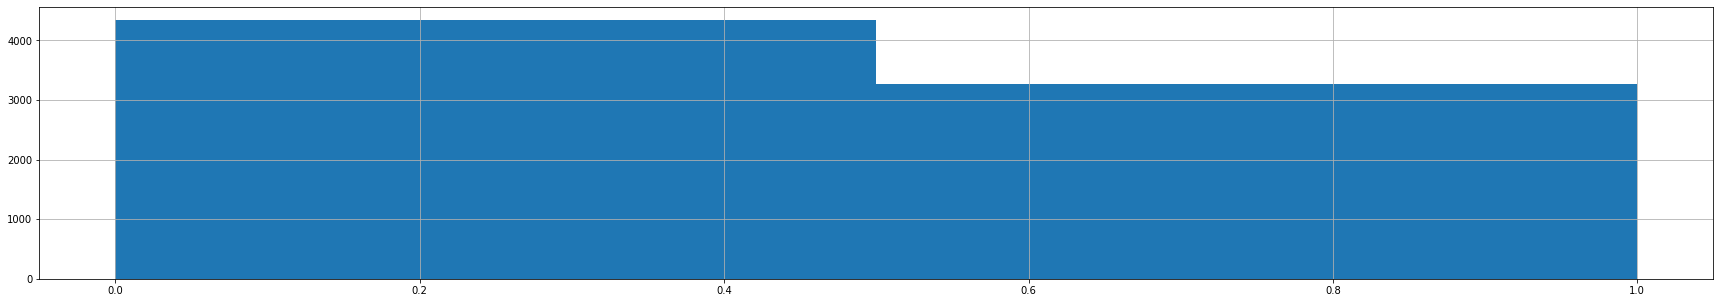

In [12]:
dataset["target"].hist(bins=2)

In [13]:
dataset[dataset["target"] == 1]["text"].values[0:100]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
       "I'm on top of the hill and I can see a fire in the woods...",
       "There's an emergency evacuation happening now in the building across the street",
       "I'm afraid that the tornado is coming to our area...",
       'Three people died from the heat wave so far',
       'Haha South Tampa is getting flooded hah-

In [14]:
dataset[dataset["target"] == 0]["text"].values[0:100]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast', 'What a goooooooaaaaaal!!!!!!',
       'this is ridiculous....', 'London is cool ;)', 'Love skiing',
       'What a wonderful day!', 'LOOOOOOL',
       "No way...I can't eat that shit", 'Was in NYC last week!',
       'Love my girlfriend', 'Cooool :)', 'Do you like pasta?',
       'The end!',
       'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
       'Crying out for more! Set me ablaze',
       'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N',
       "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.",
       'Ablaze for you Lord :D',
       'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw',
       "on the outside you're ablaze and alive\nbut you're dead inside",
       'Had an awesome time visiting the C

## Information extraction from tweets

In [15]:
dataset["text_cleaned"] = dataset.apply(lambda row: tweet_preprocessor.clean(row["text"]), axis=1)

In [16]:
dataset["text_tokenized"] = dataset.apply(lambda row: tweet_preprocessor.tokenize(row["text"]), axis=1)

In [17]:
dir(tweet_preprocessor.parse(dataset["text"].values[0]))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'emojis',
 'hashtags',
 'mentions',
 'numbers',
 'reserved',
 'reserved_words',
 'smileys',
 'urls']

In [18]:
def extract_match(text):
    return [match.match for match in text] if text is not None else text

In [19]:
dataset["text_emojis"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).emojis), axis=1)

In [20]:
dataset["text_hashtags"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).hashtags), axis=1)

In [21]:
dataset["text_mentions"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).mentions), axis=1)

In [22]:
dataset["text_numbers"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).numbers), axis=1)

In [23]:
dataset["text_reserved"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).reserved), axis=1)

In [24]:
dataset["text_reserved_words"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).reserved_words), axis=1)

In [25]:
dataset["text_smileys"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).smileys), axis=1)

In [26]:
dataset["text_urls"] = dataset.apply(lambda row: extract_match(tweet_preprocessor.parse(row["text"]).urls), axis=1)

In [27]:
dataset["keyword_cleaned"] = dataset.apply(lambda row: unquote(row["keyword"]) if pd.notnull(row["keyword"]) else None, axis=1)

In [28]:
dataset

,keyword,location,text,target,text_cleaned,text_tokenized,text_emojis,text_hashtags,text_mentions,text_numbers,text_reserved,text_reserved_words,text_smileys,text_urls,keyword_cleaned
id,,,,,,,,,,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this May ALLAH For...,Our Deeds are the Reason of this $HASHTAG$ May...,None,[#earthquake],None,None,None,None,None,None,None
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,None,None,None,None,None,None,None,None,None
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,None,None,None,None,None,None,None,None,None
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders in California,$NUMBER$ people receive $HASHTAG$ evacuation o...,None,[#wildfires],None,"[13,000]",None,None,None,None,None
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby as smoke fr...,Just got sent this photo from Ruby $HASHTAG$ a...,None,"[#Alaska, #wildfires]",None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,Two giant cranes holding a bridge collapse int...,None,None,None,None,None,None,None,[http://t.co/STfMbbZFB5],None
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,The out of control wild fires in California ev...,$MENTION$ $MENTION$ The out of control wild fi...,None,None,"[@aria_ahrary, @TheTawniest]",None,None,None,None,None,None
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. $URL$,None,None,None,None,None,None,None,[http://t.co/zDtoyd8EbJ],None


In [29]:
dataset.describe(include = 'all')

,keyword,location,text,target,text_cleaned,text_tokenized,text_emojis,text_hashtags,text_mentions,text_numbers,text_reserved,text_reserved_words,text_smileys,text_urls,keyword_cleaned
count,7552,5080,7613,7613.00000,7613,7613,0,1761,2039,1505,46,0,74,3971,7552
unique,221,3341,7503,NaN,6841,6926,0,1360,1796,573,1,0,28,3888,221
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN,Watch This Airport Get Swallowed Up By A Sands...,Watch This Airport Get Swallowed Up By A Sands...,NaN,"[#hot, #prebreak, #best]",[@YouTube],[ 2],[RT],NaN,[:)],[http://t.co/qew4c5M1xd],fatalities
freq,45,104,10,NaN,24,24,NaN,30,60,108,46,NaN,14,9,45
mean,NaN,NaN,NaN,0.42966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
dataset["text_numbers"].value_counts()

[ 2]                    108
[ 3]                     73
[ 1]                     38
[ 4]                     38
[ 5]                     38
                       ... 
[ 9,  2,  3942,  13]      1
[ 20,  60,  10]           1
[ 2003]                   1
[ 5000]                   1
[ 61]                     1
Name: text_numbers, Length: 573, dtype: int64

In [31]:
dataset["text_reserved"].value_counts()

[RT]    46
Name: text_reserved, dtype: int64

In [32]:
dataset["text_smileys"].value_counts()

[:)]            14
[:(]             9
[:D]             7
[:P]             6
[:-)]            6
                ..
[:S, :S, :s]     1
[;Do]            1
[:-D]            1
[;P]             1
[:\\\]           1
Name: text_smileys, Length: 28, dtype: int64

In [33]:
dataset["text_hashtags"].value_counts()

[#hot, #prebreak, #best]                30
[#GBBO]                                 11
[#, #, #, #]                             9
[#]                                      9
[#news]                                  9
                                        ..
[#oomf]                                  1
[#Dutton, #presser]                      1
[#RN, #Emergency, #Henderson, #jobs]     1
[#Australia, #News, #MH370]              1
[#Worm]                                  1
Name: text_hashtags, Length: 1360, dtype: int64

In [34]:
dataset["text_mentions"].value_counts()

[@YouTube]                        60
[@]                               29
[@Change]                          9
[@djicemoon]                       7
[@POTUS]                           6
                                  ..
[@BlizzHeroes, @DustinBrowder]     1
[@TheTXI, @GunnersFan89]           1
[@TANSTAAFL23]                     1
[@dicehateme, @PuppyShogun]        1
[@Matt_Kroschel]                   1
Name: text_mentions, Length: 1796, dtype: int64

In [35]:
dataset["text_urls"].value_counts()

[http://t.co/qew4c5M1xd]                            9
[http://t.co/q2eBlOKeVE, http://t.co/eNCmhz6y34]    6
[http://t.co/KSAwlYuX02]                            6
[http://t.co/cybKsXHF7d]                            5
[http://t.co/LvlH3W3aWO, http://t.co/vIwXY1XDYK]    4
                                                   ..
[http://t.co/bS6PjT09Tc]                            1
[http://t.co/9asc1hhFNJ]                            1
[http://t.co/i7EskymOec]                            1
[http://t.co/aqinaVl1b6]                            1
[http://t.co/VzgslEPkkH]                            1
Name: text_urls, Length: 3888, dtype: int64

## Correlate features with disaster/not disaster target

### Most common tokens in each class

In [36]:
def get_lemmas(text, remove_stop_words=False, remove_punctuation=False):    
    lemmas = []
    for token in nlp(text):
        if (not remove_stop_words or not token.is_stop) and (not remove_punctuation or not token.is_punct):
            lemmas.append(token.lemma_)
    return lemmas

In [37]:
train_target_zero = dataset.loc[lambda row: row["target"] == 0]
train_target_one = dataset.loc[lambda row: row["target"] == 1]

In [38]:
lemmas_for_each_text_target_zero = [get_lemmas(text, remove_stop_words=True, remove_punctuation=True) for text in train_target_zero.text_cleaned.values]
lemmas_for_each_text_target_one = [get_lemmas(text, remove_stop_words=True, remove_punctuation=True) for text in train_target_one.text_cleaned.values]

lemmas_for_target_zero = [lemma for row in lemmas_for_each_text_target_zero for lemma in row]
lemmas_for_target_one = [lemma for row in lemmas_for_each_text_target_one for lemma in row]

In [39]:
most_common_target_zero = Counter(lemmas_for_target_zero).most_common(number_most_common_features)
most_common_target_one = Counter(lemmas_for_target_one).most_common(number_most_common_features)

<BarContainer object of 30 artists>

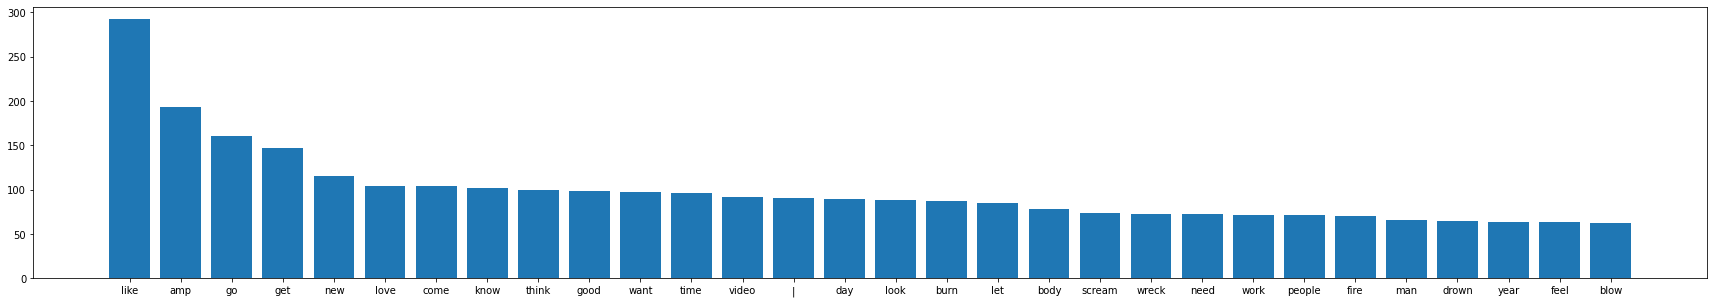

In [40]:
plt.bar([token for token, freq in most_common_target_zero], [freq for token, freq in most_common_target_zero])

<BarContainer object of 30 artists>

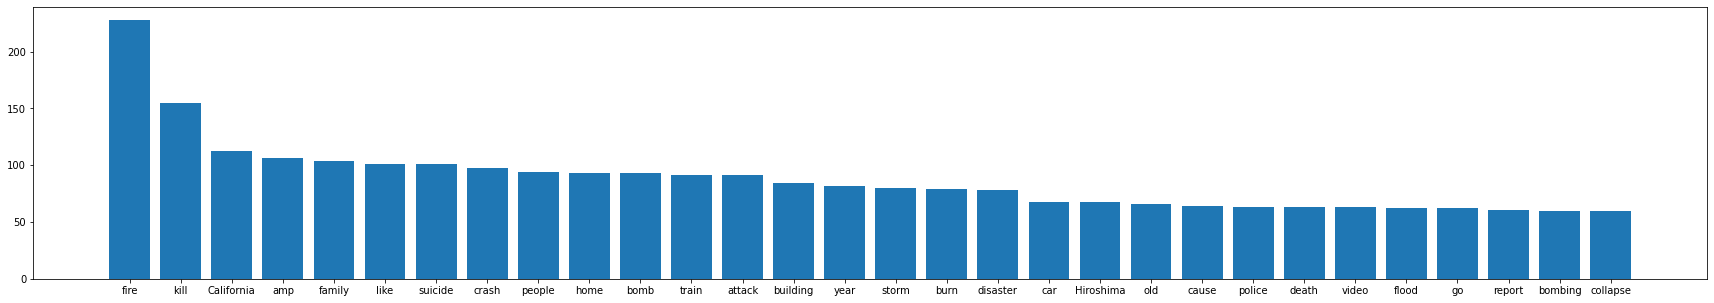

In [41]:
plt.bar([token for token, freq in most_common_target_one], [freq for token, freq in most_common_target_one])

In [42]:
lemmas_for_each_keyword_target_zero = [get_lemmas(text, remove_stop_words=False, remove_punctuation=True) if text is not None else [] for text in train_target_zero.keyword_cleaned.values]
lemmas_for_each_keyword_target_one = [get_lemmas(text, remove_stop_words=False, remove_punctuation=True) if text is not None else [] for text in train_target_one.keyword_cleaned.values]

keyword_lemmas_for_target_zero = [lemma for row in lemmas_for_each_keyword_target_zero for lemma in row]
keyword_lemmas_for_target_one = [lemma for row in lemmas_for_each_keyword_target_one for lemma in row]

In [43]:
most_common_keywords_target_zero = Counter(keyword_lemmas_for_target_zero).most_common(number_most_common_features)
most_common_keywords_target_one = Counter(keyword_lemmas_for_target_one).most_common(number_most_common_features)

<BarContainer object of 30 artists>

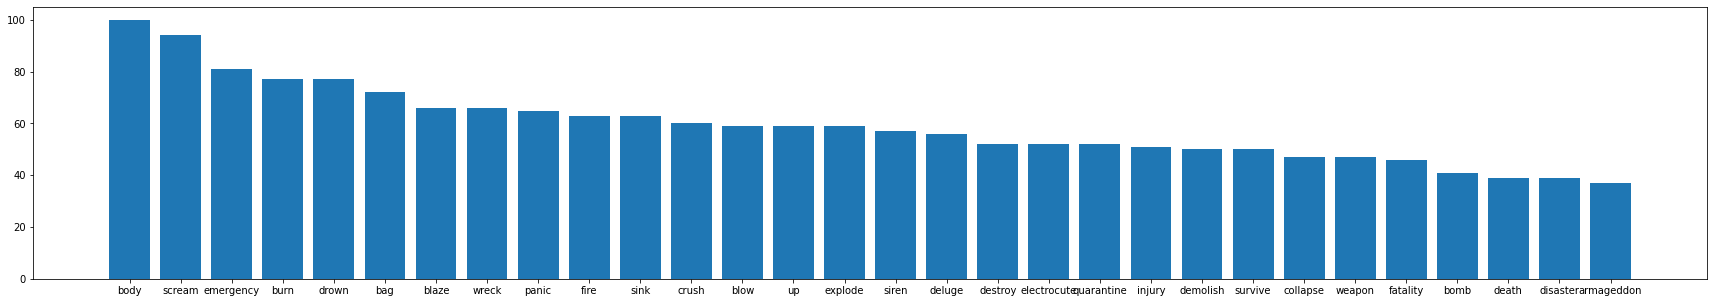

In [44]:
plt.bar([token for token, freq in most_common_keywords_target_zero], [freq for token, freq in most_common_keywords_target_zero])

<BarContainer object of 30 artists>

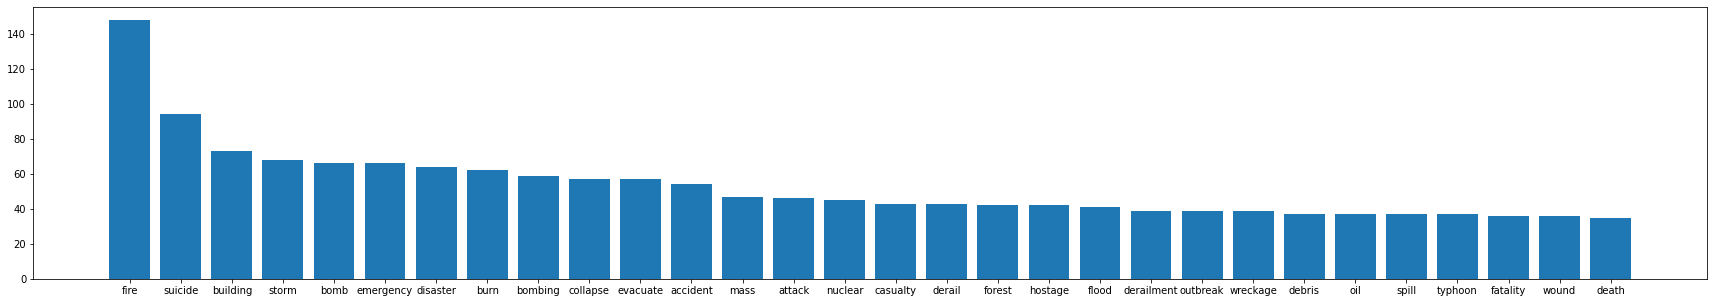

In [45]:
plt.bar([token for token, freq in most_common_keywords_target_one], [freq for token, freq in most_common_keywords_target_one])

<BarContainer object of 30 artists>

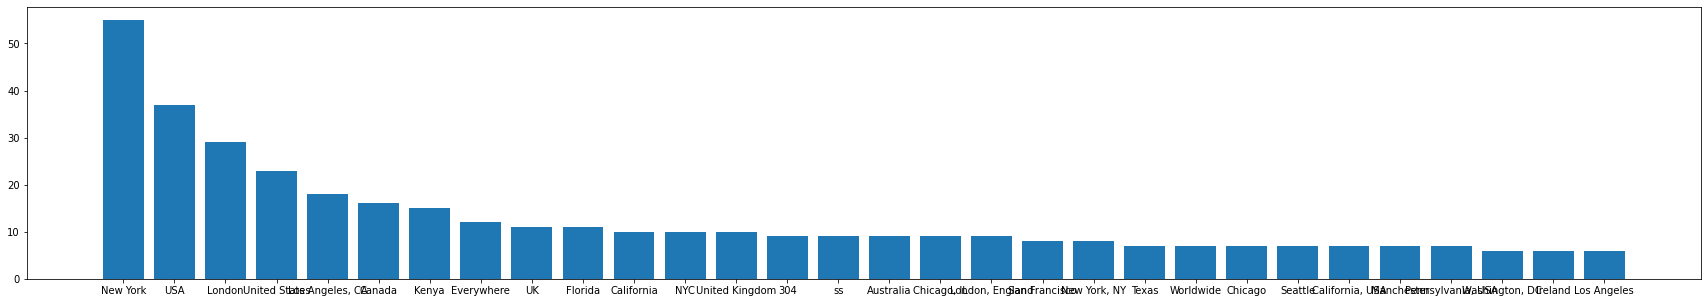

In [46]:
most_common_location_target_zero = Counter(train_target_zero.location[~train_target_zero.location.isnull()]).most_common(number_most_common_features)
plt.bar([token for token, freq in most_common_location_target_zero], [freq for token, freq in most_common_location_target_zero])

<BarContainer object of 30 artists>

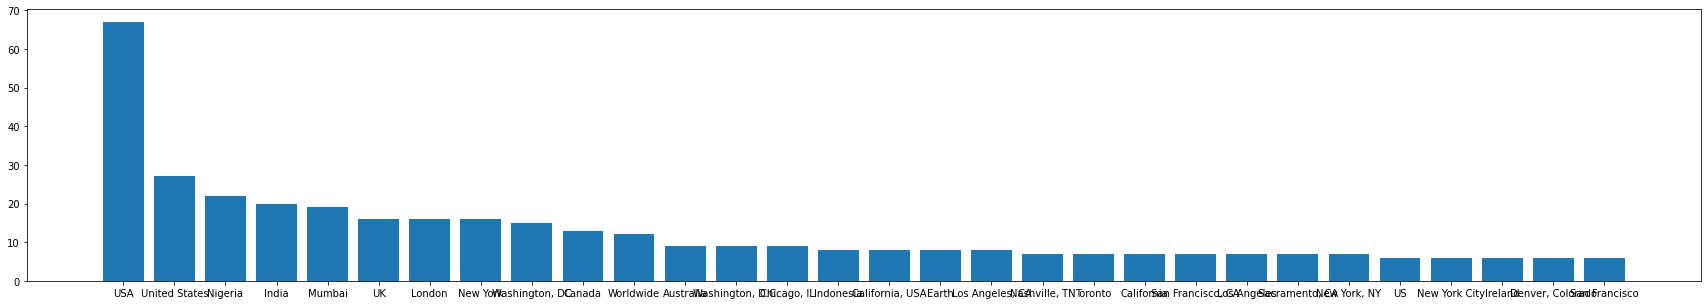

In [47]:
most_common_location_target_one = Counter(train_target_one.location[~train_target_one.location.isnull()]).most_common(number_most_common_features)
plt.bar([token for token, freq in most_common_location_target_one], [freq for token, freq in most_common_location_target_one])

In [48]:
smiles_target_zero = [smile.lower() for smiles in train_target_zero.text_smileys.values[~train_target_zero.text_smileys.isnull()] for smile in smiles]
smiles_target_one = [smile.lower() for smiles in train_target_one.text_smileys.values[~train_target_one.text_smileys.isnull()] for smile in smiles]

most_common_smiles_target_zero = Counter(smiles_target_zero).most_common(number_most_common_features)
most_common_smiles_target_one = Counter(smiles_target_one).most_common(number_most_common_features)

<BarContainer object of 18 artists>

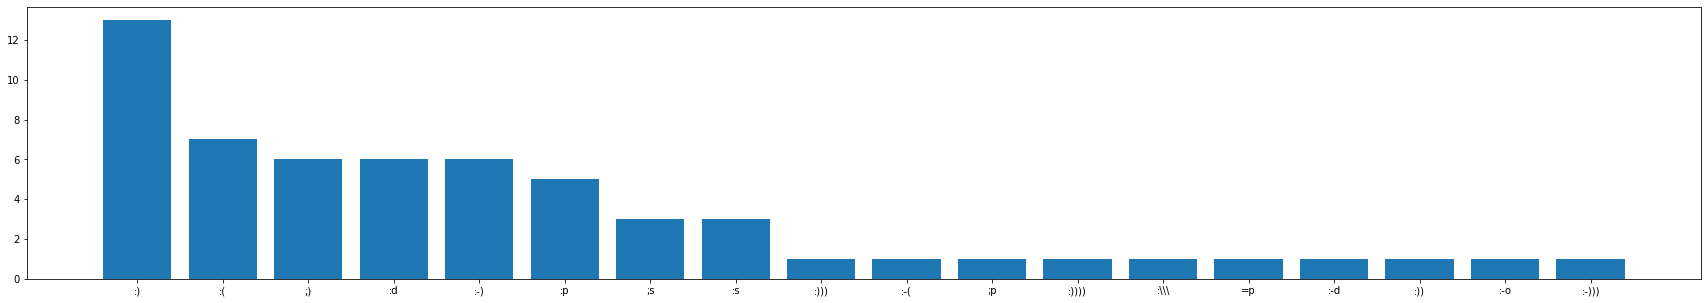

In [49]:
plt.bar([token for token, freq in most_common_smiles_target_zero], [freq for token, freq in most_common_smiles_target_zero])

<BarContainer object of 12 artists>

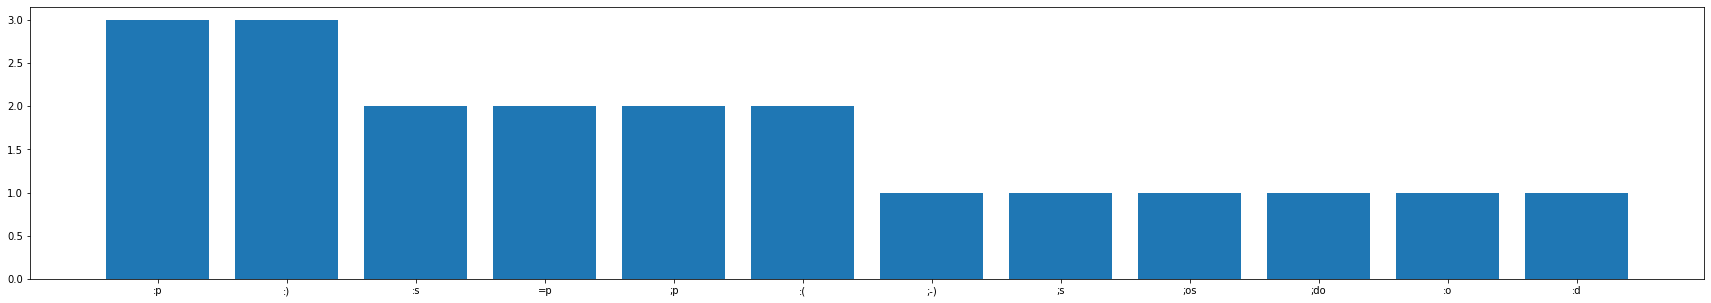

In [50]:
plt.bar([token for token, freq in most_common_smiles_target_one], [freq for token, freq in most_common_smiles_target_one])

In [51]:
hashtags_target_zero = [smile.lower() for smiles in train_target_zero.text_hashtags.values[~train_target_zero.text_hashtags.isnull()] for smile in smiles]
hashtags_target_one = [smile.lower() for smiles in train_target_one.text_hashtags.values[~train_target_one.text_hashtags.isnull()] for smile in smiles]

most_common_hashtags_target_zero = Counter(hashtags_target_zero).most_common(number_most_common_features)
most_common_hashtags_target_one = Counter(hashtags_target_one).most_common(number_most_common_features)

<BarContainer object of 30 artists>

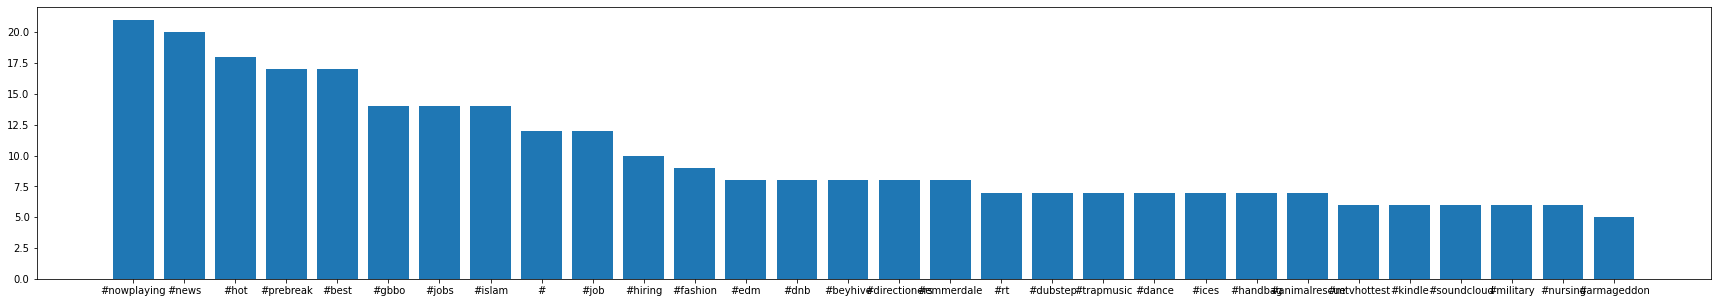

In [52]:
plt.bar([token for token, freq in most_common_hashtags_target_zero], [freq for token, freq in most_common_hashtags_target_zero])

<BarContainer object of 30 artists>

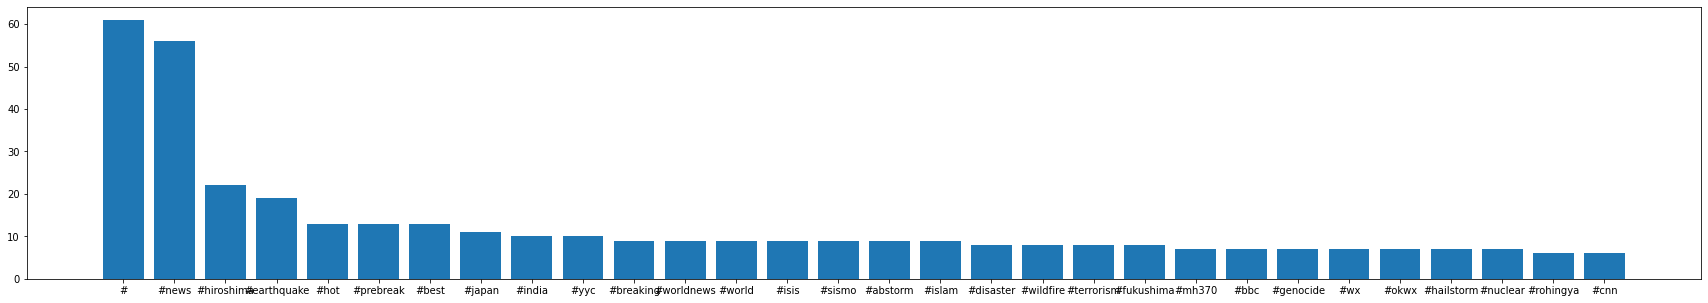

In [53]:
plt.bar([token for token, freq in most_common_hashtags_target_one], [freq for token, freq in most_common_hashtags_target_one])

In [54]:
mentions_target_zero = [smile.lower() for smiles in train_target_zero.text_mentions.values[~train_target_zero.text_mentions.isnull()] for smile in smiles]
mentions_target_one = [smile.lower() for smiles in train_target_one.text_mentions.values[~train_target_one.text_mentions.isnull()] for smile in smiles]

most_common_mentions_target_zero = Counter(mentions_target_zero).most_common(number_most_common_features)
most_common_mentions_target_one = Counter(mentions_target_one).most_common(number_most_common_features)

<BarContainer object of 30 artists>

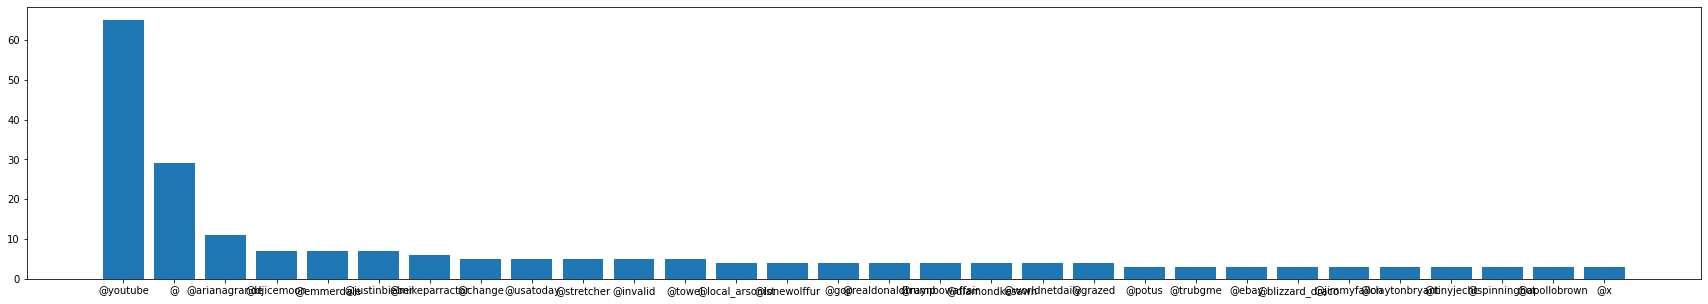

In [55]:
plt.bar([token for token, freq in most_common_mentions_target_zero], [freq for token, freq in most_common_mentions_target_zero])

<BarContainer object of 30 artists>

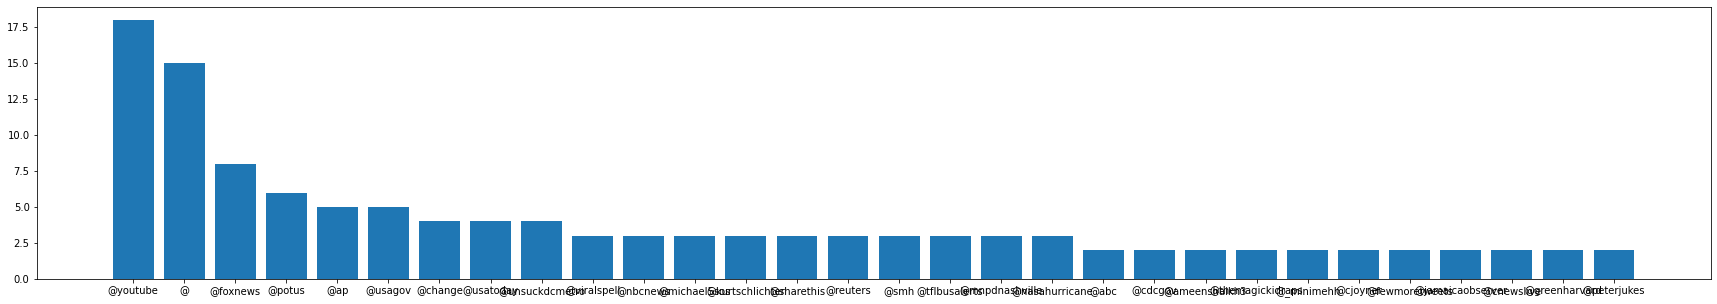

In [56]:
plt.bar([token for token, freq in most_common_mentions_target_one], [freq for token, freq in most_common_mentions_target_one])

### Number of tokens per example in each class

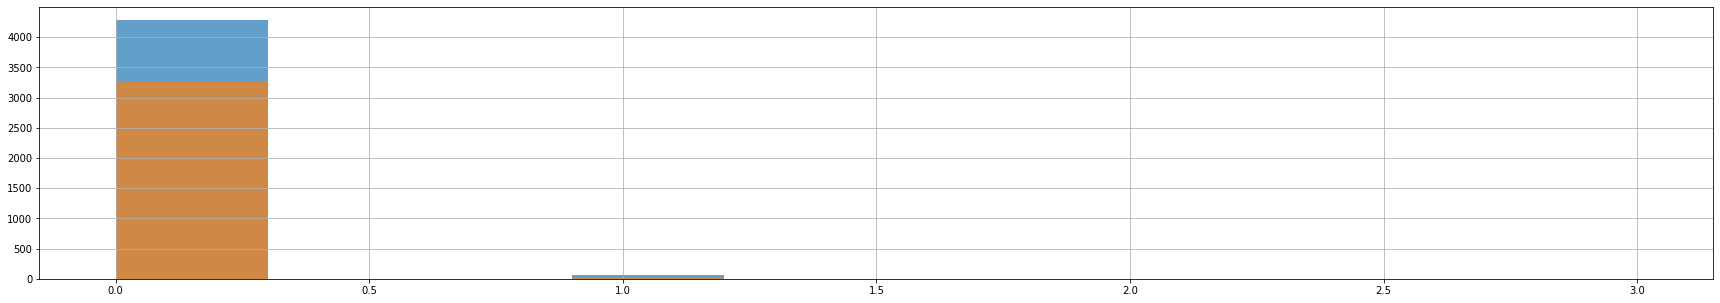

In [57]:
train_target_zero.text_smileys.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)
train_target_one.text_smileys.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)

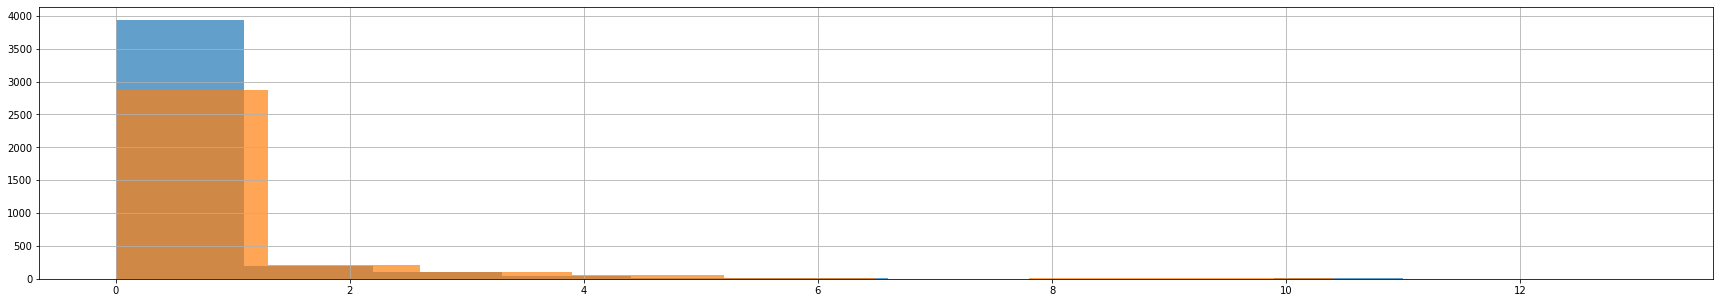

In [58]:
train_target_zero.text_hashtags.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)
train_target_one.text_hashtags.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)

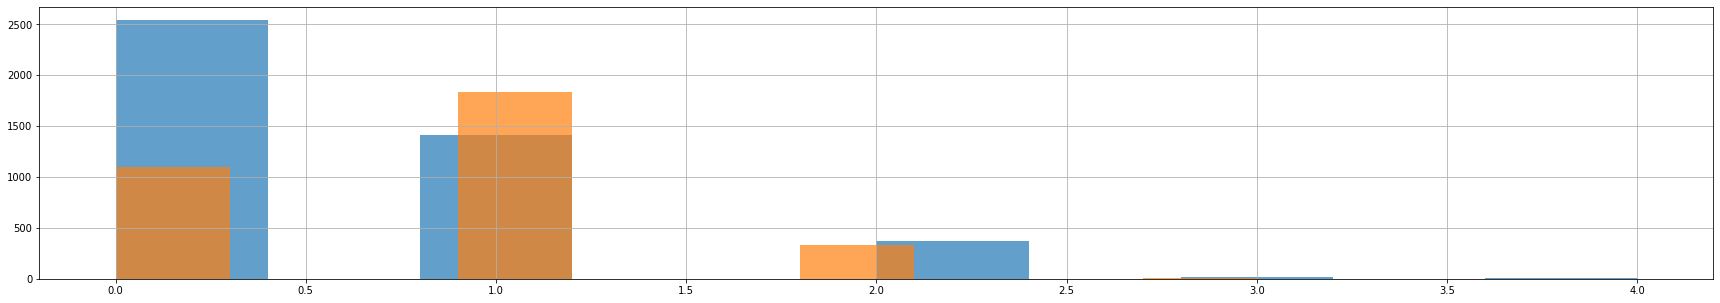

In [59]:
train_target_zero.text_urls.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)
train_target_one.text_urls.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)

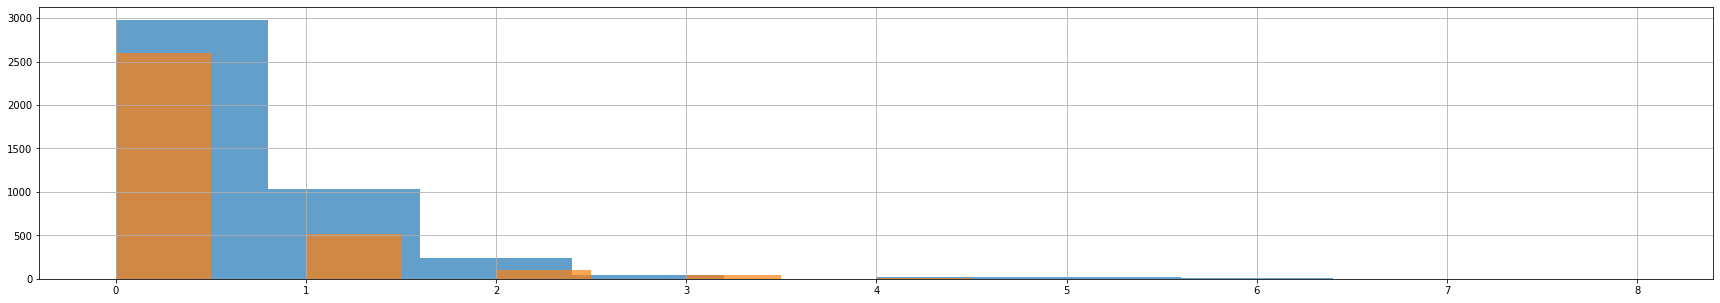

In [60]:
train_target_zero.text_mentions.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)
train_target_one.text_mentions.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)

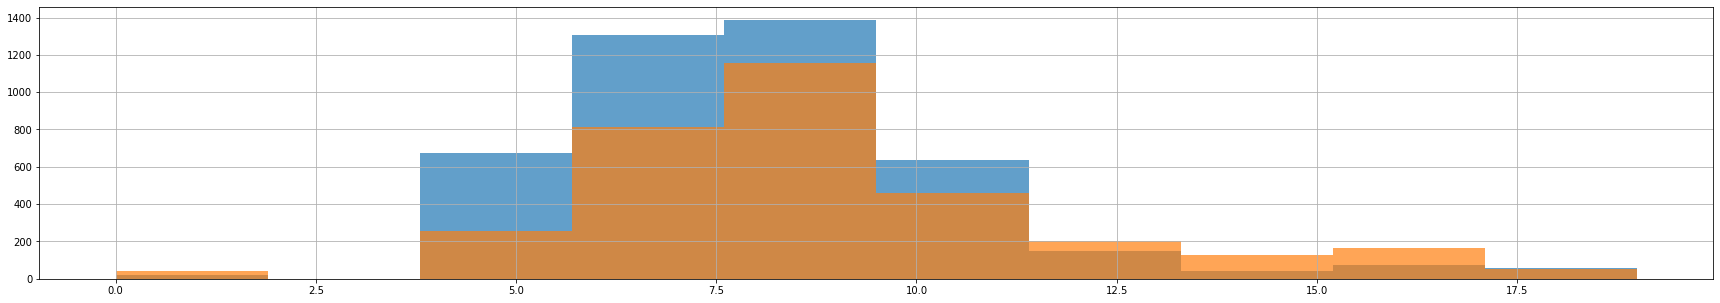

In [61]:
train_target_zero.keyword_cleaned.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)
train_target_one.keyword_cleaned.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)

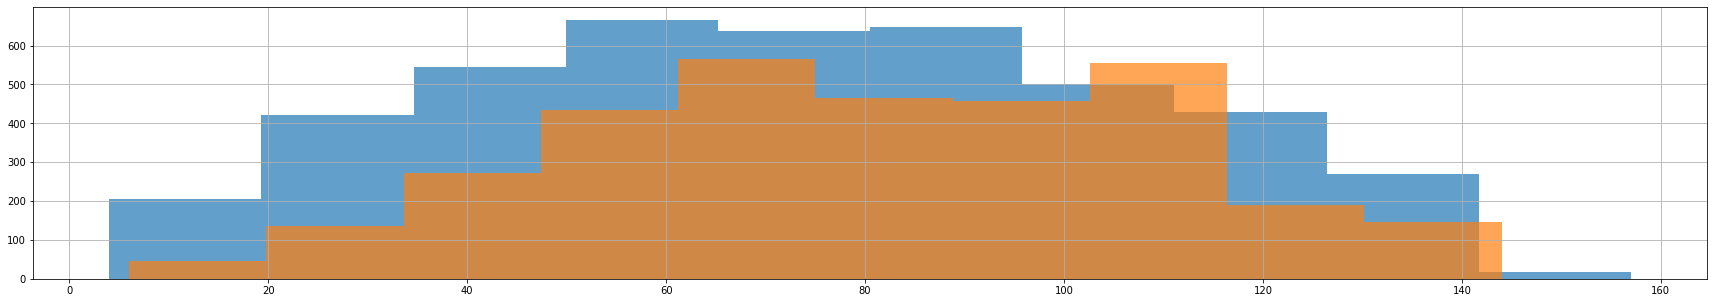

In [62]:
train_target_zero.text_cleaned.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)
train_target_one.text_cleaned.apply(lambda x: len(x) if x is not None else 0).hist(alpha=0.7)

## Conclusions

* There are 52 duplicate rows in the dataset.
* 56.8% of the tweets is classified as not disaster; the others are tweets from disaster scenes.
* Tweet text and keywords need to be cleaned before being ready to be used.
* The text and keyword tokens seem to have a big impact in the classification.
* The location tokens may have an impact in the classification.
* The hashtags, mentions and number of urls may help to classify the token.
* Emojis, numbers, reserved and reserved words do not contain any information.
* Smileys do not contain enough information to be considered relevant.